### Custom Training and Evaluation

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pprint import pprint
tf.random.set_seed(1000)
np.random.seed(1000)

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

labelencoder = LabelEncoder()
train_df['thal'] = labelencoder.fit_transform(train_df['thal'])
test_df['thal'] = labelencoder.transform(test_df['thal'])

train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=133, shuffle= True)

train_labels = tf.keras.utils.to_categorical(train_data.pop('target'), 2)
val_labels = tf.keras.utils.to_categorical(val_data.pop('target'), 2)
test_labels = tf.keras.utils.to_categorical(test_df.pop('target'), 2)

train_data = train_data.values.astype("float32")
val_data = val_data.values.astype("float32")
test_data = test_df.values.astype("float32")

### Custom loss

In [3]:
# Creating Custom Loss
def make_loss_fn(wp, wn, epsilon = 1e-7):
    wp = tf.cast(tf.constant(wp), tf.float32)
    wn = tf.cast(tf.constant(wn), tf.float32)
    def weighted_binary_crossentropy(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        loss = -tf.reduce_mean(tf.add(tf.multiply(wp ,tf.multiply(y_true, tf.math.log(y_pred + epsilon))), tf.multiply(wn, tf.multiply(1 - y_true, tf.math.log(1 - y_pred + epsilon)))))
        return loss
    return weighted_binary_crossentropy



# Creating Custom Loss
class WeightedBinaryCrossEntropy(tf.keras.losses.Loss):
    def __init__(self, wp, wn, epsilon = 1e-7, name="weighted_binary_crossentropy", **kwargs):
        super().__init__(name=name, **kwargs)
        self.wp = tf.cast(tf.constant(wp), tf.float32)
        self.wn = tf.cast(tf.constant(wn), tf.float32)
        self.epsilon = epsilon

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        loss = -tf.reduce_mean(tf.add(tf.multiply(self.wp ,tf.multiply(y_true, tf.math.log(y_pred + self.epsilon))), tf.multiply(self.wn,tf.multiply(1 - y_true, tf.math.log(1 - y_pred + self.epsilon)))))
        return loss
    
    def get_config(self):
        config = super().get_config()
        config.update({"wp": self.wp.numpy(), "wn": self.wn.numpy()})
        return config
    

In [4]:
# Testing Loss
y_true = np.array([[0,1], [1,0], [1,0],[1,0]])
y_pred = np.random.uniform(0.0,0.5,(4,2))

loss_fn = make_loss_fn([1], [1])
print(loss_fn(y_true, y_pred))
bc = tf.keras.losses.BinaryCrossentropy()
print(bc(y_true, y_pred))
wbc = WeightedBinaryCrossEntropy([1],[1])
print(wbc(y_true, y_pred))

tf.Tensor(1.166158, shape=(), dtype=float32)
tf.Tensor(1.1661579608917236, shape=(), dtype=float64)
tf.Tensor(1.166158, shape=(), dtype=float32)


### Custom Metric

In [5]:
# Creating Custom Metric
class CustomAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name = 'custom_accuracy', **kwargs):
        super().__init__(name = name, **kwargs)
        self.count = self.add_weight(name = 'count', initializer = 'zeros')
        self.total = self.add_weight(name = 'total', initializer = 'zeros')
        self.custom_accuracy = self.add_weight(name = 'custom_acc', initializer = 'zeros')
    
    def update_state(self, y_true, y_pred, sample_weight = None): 
        correct_values = tf.reduce_sum(tf.cast(tf.argmax(y_pred, axis = 1) == tf.argmax(y_true, axis = 1), "float32"))
        self.count.assign_add(correct_values)
        self.total.assign_add(tf.cast(tf.shape(y_true)[0], "float32"))
        self.custom_accuracy.assign(self.count / self.total)
        
    def result(self):
        return self.custom_accuracy
    
    def reset_states(self):
        self.count.assign(0.0)
        self.total.assign(0.0)
        self.custom_accuracy.assign(0.0)
        


# class MTCF1Score(tfa.metrics.FBetaScore):
#     def __init__(self,num_classes, threshold = 0.5, beta = 1.0, name="mtc_f1_score", **kwargs):
#         super().__init__(num_classes,threshold = threshold, beta = beta, name = name, **kwargs)
#         self.mtc_f1_score = self.add_weight(name="mtc", initializer="zeros")

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         super().update_state(y_true, y_pred, sample_weight=None)

#     def result(self):
#         f1_score = super().result()
#         self.mtc_f1_score.assign(f1_score.shape[0] / tf.reduce_sum(1 / f1_score))
#         return self.mtc_f1_score

#     def reset_states(self):
#         self.mtc_f1_score.assign(0.0)

In [6]:
# Testing Metric
y_true = np.array([[0,1], [1,0], [1,0],[1,0]])
y_pred = np.random.uniform(0.0,1.0,(4,2))


m = tf.keras.metrics.CategoricalAccuracy()
m.update_state(y_true, y_pred)
print(m.result().numpy())


m = CustomAccuracy()
m.update_state(y_true, y_pred)
print(m.result().numpy())

0.75
0.75


### Custom Layer

In [7]:
class CustomDense(tf.keras.layers.Layer):
    def __init__(self, units=32, activation_fn = None, **kwargs):
        super(CustomDense, self).__init__(**kwargs)
        self.units = units
        self.activation_fn = activation_fn

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), 
            initializer="zeros", 
            trainable=True
        )

    def call(self, inputs):
        if self.activation_fn == None:
            return tf.matmul(inputs, self.w) + self.b
        else:
            return self.activation_fn(tf.matmul(inputs, self.w) + self.b)
        
    def get_config(self):
        config = super().get_config()
        config.update({"units": self.units, "activation_fn":self.activation_fn})
        return config
    

d1 = CustomDense(32, tf.keras.activations.relu)
d1(train_data)

<tf.Tensor: shape=(192, 32), dtype=float32, numpy=
array([[ 0.      ,  0.      ,  0.      , ..., 66.29566 , 44.593117,
        39.6206  ],
       [ 0.      ,  0.      ,  0.      , ..., 47.775726, 31.496809,
        22.897074],
       [ 0.      ,  0.      ,  0.      , ..., 66.34289 , 43.028225,
        37.84705 ],
       ...,
       [ 0.      ,  0.      ,  0.      , ..., 49.276707, 41.988388,
        24.907057],
       [ 0.      ,  0.      ,  0.      , ..., 30.521652, 11.87484 ,
        13.555855],
       [ 0.      ,  0.      ,  0.      , ..., 29.705513, 24.477777,
         8.244018]], dtype=float32)>

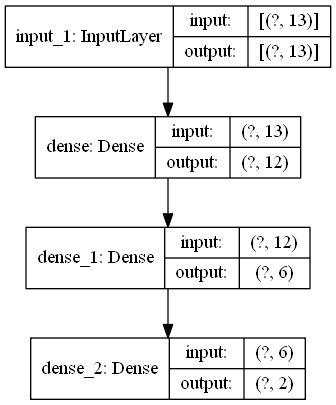

In [8]:
def create_model():
    input1 = tf.keras.Input(shape=(13,))
    hidden1 = tf.keras.layers.Dense(units = 12, activation='relu')(input1)
    hidden2 = tf.keras.layers.Dense(units = 6, activation='relu')(hidden1)
    output1 = tf.keras.layers.Dense(units = 2, activation='sigmoid')(hidden2)
    
    model = tf.keras.models.Model(inputs = input1, outputs = output1, name= "functional1")
    
    
    model.compile(optimizer='adam',
#                   loss = make_loss_fn([1], [1]),
                  loss= WeightedBinaryCrossEntropy(wp = [1], wn = [1]),
                  metrics=['accuracy', CustomAccuracy()]
                 )
    return model
model = create_model()
tf.keras.utils.plot_model(model, 'my_first_model.png', show_shapes=True)

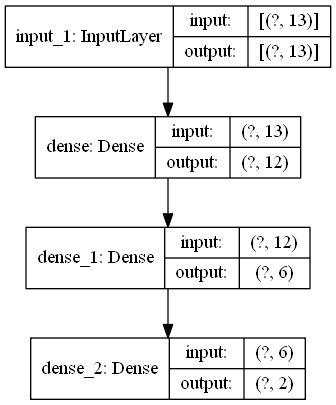

In [9]:
def create_model1():
    input1 = tf.keras.Input(shape=(13,))
    hidden1 = CustomDense(12, tf.keras.activations.relu)(input1)
    hidden2 = CustomDense(6, tf.keras.activations.relu)(hidden1)
    output1 = CustomDense(2, tf.keras.activations.sigmoid)(hidden2)
    
    model = tf.keras.models.Model(inputs = input1, outputs = output1, name= "functional1")
    
    
    model.compile(optimizer='adam',
#                   loss = make_loss_fn([1], [1]),
                  loss= WeightedBinaryCrossEntropy(wp = [1], wn = [1]),
                  metrics=['accuracy', CustomAccuracy()]
                 )
    return model
model1 = create_model1()
tf.keras.utils.plot_model(model, 'my_first_model.png', show_shapes=True)

In [10]:
# setting same weights
model1.set_weights(model.get_weights())

In [11]:
# Getting loss
pred = model(train_data)
wbc = WeightedBinaryCrossEntropy([1],[1])
print(wbc(train_labels, pred))

pred = model1(train_data)
wbc = WeightedBinaryCrossEntropy([1],[1])
print(wbc(train_labels, pred))

tf.Tensor(9.106158, shape=(), dtype=float32)
tf.Tensor(9.106158, shape=(), dtype=float32)


In [12]:
history = model.fit(
    x = train_data, 
    y = train_labels,
    batch_size = 1000,
    epochs = 10,
    validation_data = (val_data, val_labels),
)

Epoch 1/10
1/1 [==============================] - 0s 129ms/step - loss: 9.0416 - accuracy: 0.2656 - custom_accuracy: 0.2656 - val_loss: 8.2820 - val_accuracy: 0.2708 - val_custom_accuracy: 0.2708
Epoch 2/10
1/1 [==============================] - 0s 18ms/step - loss: 8.4705 - accuracy: 0.2656 - custom_accuracy: 0.2656 - val_loss: 7.7206 - val_accuracy: 0.2708 - val_custom_accuracy: 0.2708
Epoch 3/10
1/1 [==============================] - 0s 16ms/step - loss: 7.9028 - accuracy: 0.2656 - custom_accuracy: 0.2656 - val_loss: 7.1855 - val_accuracy: 0.2708 - val_custom_accuracy: 0.2708
Epoch 4/10
1/1 [==============================] - 0s 18ms/step - loss: 7.3556 - accuracy: 0.2656 - custom_accuracy: 0.2656 - val_loss: 6.7266 - val_accuracy: 0.2708 - val_custom_accuracy: 0.2708
Epoch 5/10
1/1 [==============================] - 0s 18ms/step - loss: 6.8629 - accuracy: 0.2656 - custom_accuracy: 0.2656 - val_loss: 6.4055 - val_accuracy: 0.2708 - val_custom_accuracy: 0.2708
Epoch 6/10
1/1 [========

In [13]:
history = model1.fit(
    x = train_data, 
    y = train_labels,
    batch_size = 1000,
    epochs = 10,
    validation_data = (val_data, val_labels),
)

Epoch 1/10
1/1 [==============================] - 0s 108ms/step - loss: 9.0416 - accuracy: 0.2656 - custom_accuracy: 0.2656 - val_loss: 8.2820 - val_accuracy: 0.2708 - val_custom_accuracy: 0.2708
Epoch 2/10
1/1 [==============================] - 0s 16ms/step - loss: 8.4705 - accuracy: 0.2656 - custom_accuracy: 0.2656 - val_loss: 7.7206 - val_accuracy: 0.2708 - val_custom_accuracy: 0.2708
Epoch 3/10
1/1 [==============================] - 0s 17ms/step - loss: 7.9028 - accuracy: 0.2656 - custom_accuracy: 0.2656 - val_loss: 7.1855 - val_accuracy: 0.2708 - val_custom_accuracy: 0.2708
Epoch 4/10
1/1 [==============================] - 0s 17ms/step - loss: 7.3556 - accuracy: 0.2656 - custom_accuracy: 0.2656 - val_loss: 6.7266 - val_accuracy: 0.2708 - val_custom_accuracy: 0.2708
Epoch 5/10
1/1 [==============================] - 0s 16ms/step - loss: 6.8629 - accuracy: 0.2656 - custom_accuracy: 0.2656 - val_loss: 6.4055 - val_accuracy: 0.2708 - val_custom_accuracy: 0.2708
Epoch 6/10
1/1 [========

In [14]:
custom_objects = {"CustomDense": CustomDense, "CustomAccuracy": CustomAccuracy, "WeightedBinaryCrossEntropy":WeightedBinaryCrossEntropy}
tf.keras.models.save_model(model, 'custom.h5')

In [15]:
new_model = tf.keras.models.load_model('custom.h5', custom_objects=custom_objects)

In [19]:
history = new_model.fit(
    x = train_data, 
    y = train_labels,
    batch_size = 1000,
    epochs = 100,
    validation_data = (val_data, val_labels),
)

Epoch 1/100
1/1 [==============================] - 0s 34ms/step - loss: 6.3792 - accuracy: 0.2708 - custom_accuracy: 0.2708 - val_loss: 6.4130 - val_accuracy: 0.2708 - val_custom_accuracy: 0.2708
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 6.3146 - accuracy: 0.2708 - custom_accuracy: 0.2708 - val_loss: 6.3369 - val_accuracy: 0.2708 - val_custom_accuracy: 0.2708
Epoch 3/100
1/1 [==============================] - 0s 18ms/step - loss: 6.2558 - accuracy: 0.2708 - custom_accuracy: 0.2708 - val_loss: 6.2705 - val_accuracy: 0.2708 - val_custom_accuracy: 0.2708
Epoch 4/100
1/1 [==============================] - 0s 16ms/step - loss: 6.2112 - accuracy: 0.2708 - custom_accuracy: 0.2708 - val_loss: 6.2227 - val_accuracy: 0.2708 - val_custom_accuracy: 0.2708
Epoch 5/100
1/1 [==============================] - 0s 17ms/step - loss: 6.1884 - accuracy: 0.2708 - custom_accuracy: 0.2708 - val_loss: 6.1996 - val_accuracy: 0.2708 - val_custom_accuracy: 0.2708
Epoch 6/100
1/1 [===

Epoch 43/100
1/1 [==============================] - 0s 18ms/step - loss: 6.1214 - accuracy: 0.2656 - custom_accuracy: 0.2656 - val_loss: 6.0946 - val_accuracy: 0.2708 - val_custom_accuracy: 0.2708
Epoch 44/100
1/1 [==============================] - 0s 17ms/step - loss: 6.1199 - accuracy: 0.2656 - custom_accuracy: 0.2656 - val_loss: 6.0905 - val_accuracy: 0.2708 - val_custom_accuracy: 0.2708
Epoch 45/100
1/1 [==============================] - 0s 16ms/step - loss: 6.1180 - accuracy: 0.2656 - custom_accuracy: 0.2656 - val_loss: 6.0860 - val_accuracy: 0.2708 - val_custom_accuracy: 0.2708
Epoch 46/100
1/1 [==============================] - 0s 18ms/step - loss: 6.1160 - accuracy: 0.2656 - custom_accuracy: 0.2656 - val_loss: 6.0817 - val_accuracy: 0.2708 - val_custom_accuracy: 0.2708
Epoch 47/100
1/1 [==============================] - 0s 16ms/step - loss: 6.1143 - accuracy: 0.2656 - custom_accuracy: 0.2656 - val_loss: 6.0779 - val_accuracy: 0.2708 - val_custom_accuracy: 0.2708
Epoch 48/100
1/